In [185]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as anm
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['animation.html'] = 'html5'

import sys
import time

In [273]:
# Time step progress bar
def update_progress_bar(current, total):
    sys.stdout.write('\rTime step: [{:<50}] {:.0f}/{:.0f} ({:.2f}%)'.format('=' * int(current/total * 50), current, total, current*100/total))
    sys.stdout.flush()

## Solution Algorithm
In the Primitive Variable Approach the "primitive" variables (viz., u, v and p) are directly solved for rather than relying on the Stream function and Vorticity equations.

Considering a 2D incompressible Newtonian fluid flow, the **Pressure projection method** will be used here. The governing equations are:

$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0$$
$$\frac{\partial u}{\partial t} + \frac{\partial (uu)}{\partial x} + \frac{\partial (uv)}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x} + \nu\nabla^2 u$$
$$\frac{\partial v}{\partial t} + \frac{\partial (uv)}{\partial x} + \frac{\partial (vv)}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y} + \nu\nabla^2 v$$

Using FTCS scheme and in vector form:

$$\frac{\textbf{u}_{\text{i,j}}^{\text{n+1}} - \textbf{u}_{\text{i,j}}^{\text{n}}}{\Delta t} = -\textbf{A}_{\text{i,j}}^{\text{n}} + \textbf{D}_{\text{i,j}}^{\text{n}} - \frac{\nabla p_{i, j}}{\rho}$$

where,

$$\textbf{u} = \begin{bmatrix}
    u \\
    v \\
\end{bmatrix} \qquad
\textbf{A} = \begin{bmatrix}
    \frac{\partial (uu)}{\partial x} + \frac{\partial (uv)}{\partial y} \\
    \frac{\partial (uv)}{\partial x} + \frac{\partial (vv)}{\partial y} \\
\end{bmatrix} \qquad
\textbf{D} = \begin{bmatrix}
    \nu\nabla^2 u \\
    \nu\nabla^2 v \\
\end{bmatrix}\qquad
\nabla p = \begin{bmatrix}
    \frac{\partial p}{\partial x} \\
    \frac{\partial p}{\partial y} \\
\end{bmatrix}$$

Since both the velocities and pressure are unknown and coupled together, a **Predictor-Corrector** iterative method is used for the velocity.

$$\frac{\partial\widetilde{\textbf{u}}}{\partial t} = -\textbf{A} + \textbf{D}$$

Where $\widetilde{\textbf{u}}$ is the predictor velocity. Discretizing,

$$\frac{\widetilde{\textbf{u}}_{\text{i,j}}^{\text{n+1}} - \textbf{u}_{\text{i,j}}^{\text{n}}}{\Delta t} = -\textbf{A}_{\text{i,j}}^{\text{n}} + \textbf{D}_{\text{i,j}}^{\text{n}} \tag{1} \label{eq1}$$

This predictor velocity is corrected using the correction step:

$$\frac{\textbf{u}_{\text{i,j}}^{\text{n+1}} - \widetilde{\textbf{u}}_{\text{i,j}}^{\text{n+1}}}{\Delta t} = -\frac{\nabla p_{i, j}}{\rho} \tag{2} \label{eq2}$$

The pressure values in the correction step are calculated by taking a divergence of the correction equation. The key assumption is that, as the solution proceeds in time, the divergence of velocity field gets closer to 0. Hence, $div \ \textbf{u}_{\text{i,j}}^{\text{n+1}} = 0$. Also keeping in mind that $div(\nabla scalar) = \nabla^2 scalar$, the Pressure Poisson equation is:

$$div\ \widetilde{\textbf{u}}_{\text{i,j}}^{\text{n+1}} = \frac{\Delta t}{\rho}\nabla^2p \tag{3} \label{eq3}$$

where,

$$div\ \widetilde{\textbf{u}}_{\text{i,j}}^{\text{n+1}} = \frac{\partial \widetilde{u}_{\text{i,j}}^{\text{n+1}}}{\partial x} + \frac{\partial \widetilde{v}_{\text{i,j}}^{\text{n+1}}}{\partial y} $$

which can be discretized using a CDS.

The solution algorithm hence is:
1. Initialise u, v and p values over the domain and set the boundary conditions.
2. Predictor Step: Solve for $\widetilde{\textbf{u}}$ by computing $\textbf{A}$ and $\textbf{D}$ using equation $\eqref{eq1}$
3. Solve the Pressure-Poisson equation $\eqref{eq3}$ from the calculated values of $\widetilde{\textbf{u}}$ from step 2. Solving the PPE requires inner-iterations using schemes like the Gauss-Seidel
4. Corrector Step: Solve for corrected velocity $\textbf{u}$ using the pressure values calculated in step 3 using equation $\eqref{eq2}$
5. Repeat steps 2-4 till time completion

## Boundary conditions:

The boundary conditions in the primitive variable method are quite straightforward. For the pressure, from equation $\eqref{eq2}$ it can be observed that both the predictor and corrector velocities $\textbf{u}$ and $\widetilde{\textbf{u}}$ are held to the same boundary conditions. Thus, for all boundaries, we have:

$$\left.\frac{\partial p}{\partial n}\right|_{boundaries} = 0$$

But since all boundaries can't be zero Neumann conditions (atleast one Dirichlet/essential boundary condition is necessary), for the Lid-Driven cavity problem, the top wall is set to an arbitrary constant pressure value. Say 0 (atmospheric pressure in gauge units)

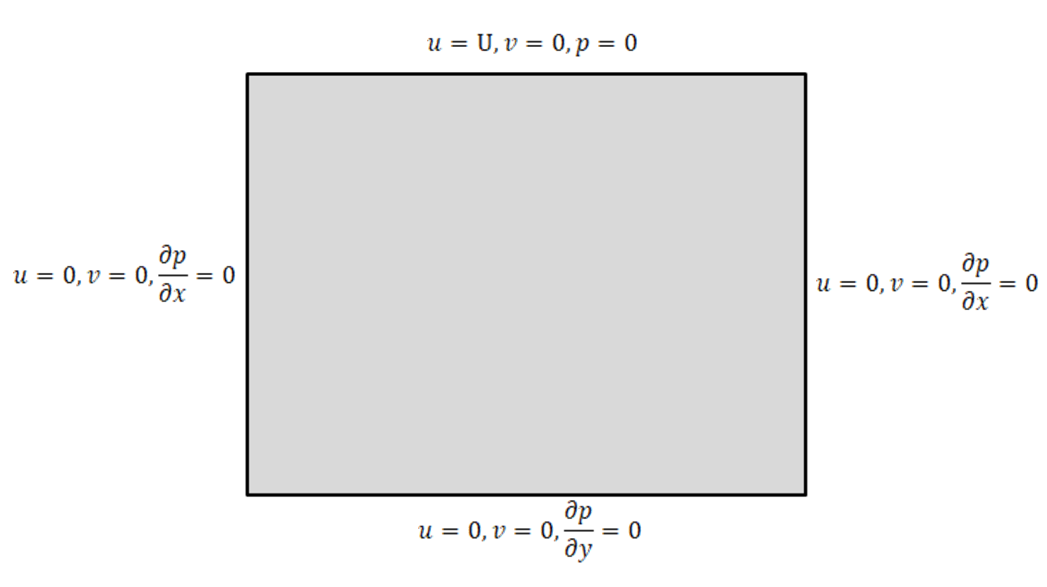

## Stability crtieria

For the linear advection-diffusion equatio, the following stability criteria is required for the FTCS scheme

$$\frac{\mu\Delta t}{min(\Delta x^2, \Delta y^2)} \le \frac{1}{4} \qquad AND \qquad \frac{(|U|^2+|V|^2)\Delta t}{\mu}\le4$$

based on which the time step size and grid sizes should be calculated. Although the Navier-Stokes equation's discretization may not follow the above exact rules, these can serve as good guidelines for the (non-linear) convection-diffusion equations of the Navier-Stokes as well.

Reynolds number = 20.0

Minimum required time step: 0.005202913631633714s
Selected time step = 0.0025974025974025974s
Total number of time steps = 385

Stability Criteria 1 (0.25: dimensionless): True (0.12480519480519482)
Stability Criteria 2 (4: dimensionless): True (0.10389610389610389)

Computational domain:


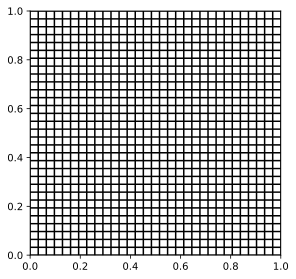

In [280]:
ut = 1 # Top wall velocity
tf = 1 # Total time of simulation.
ν = 0.05 # Kinematic viscosity of fluid
ρ = 1 # Density of fluid

nx = 32 # Grid points along x
ny = 32 # Grid points along y
Lx = 1 # Length of domain along x
Ly = 1 # Length of domain along y
dx = Lx/(nx - 1)
dy = Ly/(ny - 1)

print(f'Reynolds number = {ut*Lx/ν}')
print(f'\nMinimum required time step: {min(0.25*dx*dx/ν, (4*ν)/(ut*ut))}s')
dt = min(0.25*(min(dx, dy)**2)/ν, (4*ν)/(ut*ut))/2
ts = math.ceil(tf/dt)
dt = tf/ts
print(f'Selected time step = {dt}s\nTotal number of time steps = {ts}')
print(f'\nStability Criteria 1 (0.25: dimensionless): {(ν*dt)/(min(dx, dy)**2) < 0.25} ({(ν*dt)/(min(dx, dy)**2)})')
print(f'Stability Criteria 2 (4: dimensionless): {(ut*ut*dt)/ν < 4} ({(2*ut*ut*dt)/ν})')


# Plot computational domain
print('\nComputational domain:')
xs, ys = np.meshgrid(np.linspace(0, Lx, nx), np.linspace(0, Ly, ny))
pw = 4.5
fig, ax = plt.subplots(figsize = (pw, (pw*Ly)/Lx))
ax.plot(xs, ys, c = 'k')
ax.plot(np.transpose(xs), np.transpose(ys), c = 'k')
ax.set(xlim = [0, Lx], ylim = [0, Ly])
plt.show()

In [217]:
# Initialise velocities and pressure as zeroes
u_0 = np.zeros([ny, nx])
v_0 = np.zeros([ny, nx])
p_0 = np.zeros([ny, nx])

u_0[-1, :] = ut
vel_0 = np.sqrt(u_0**2 + v_0**2)

In [218]:
ϵ = 1e-3 # Convergence tolerance
max_itr = 100 # Maximum number of inner iterations for psi in each time step
Ap = 0.5/(dx*dx + dy*dy)

# Empty lists for u, v, p to store solutions at each time step
p_sol, vel_sol, u_sol, v_sol = [], [], [], []
u_sol.append(u_0)
v_sol.append(v_0)
p_sol.append(p_0)
vel_sol.append(vel_0)

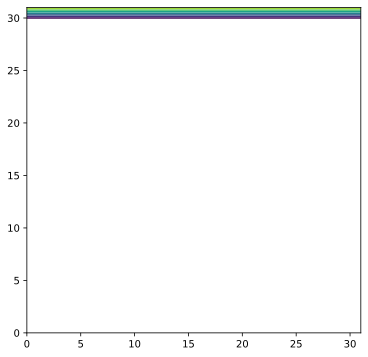

In [219]:
# Plotting initial contour
plt.figure(figsize = (6,6))
plt.contour(vel_sol[0])

In [220]:
start = time.time()
t = 0
while t < tf:
    
    u_n = u_sol[-1]
    v_n = v_sol[-1]
    u_n1 = u_sol[-1].copy()
    v_n1 = v_sol[-1].copy()
    u_p = u_sol[-1].copy()
    v_p = v_sol[-1].copy()
    
    # Advective term for x and y NS
    Ax = (u_n[1:-1, 2:]*u_n[1:-1, 2:] - u_n[1:-1, :-2]*u_n[1:-1, :-2])/(2*dx) \
        + (u_n[2:, 1:-1]*v_n[2:, 1:-1] - u_n[:-2, 1:-1]*v_n[:-2, 1:-1])/(2*dy)
    Ay = (u_n[1:-1, 2:]*v_n[1:-1, 2:] - u_n[1:-1, :-2]*v_n[1:-1, :-2])/(2*dx) \
        + (v_n[2:, 1:-1]*v_n[2:, 1:-1] - v_n[:-2, 1:-1]*v_n[:-2, 1:-1])/(2*dy)

    # Diffusion term for x and y NS
    Dx = (u_n[1:-1, 2:] - 2*u_n[1:-1, 1:-1] + u_n[1:-1, :-2])/(dx*dx) \
        + (u_n[2:, 1:-1] - 2*u_n[1:-1, 1:-1] + u_n[:-2, 1:-1])/(dy*dy)
    Dy = (v_n[1:-1, 2:] - 2*v_n[1:-1, 1:-1] + v_n[1:-1, :-2])/(dx*dx) \
        + (v_n[2:, 1:-1] - 2*v_n[1:-1, 1:-1] + v_n[:-2, 1:-1])/(dy*dy)
    
    # Predictor step
    rhs_x = ν*Dx - Ax
    rhs_y = ν*Dy - Ay
    u_p[1:-1, 1:-1] = u_n[1:-1, 1:-1] + dt*rhs_x
    v_p[1:-1, 1:-1] = v_n[1:-1, 1:-1] + dt*rhs_y
    
    # Solving the PPE
    ppe_rhs = np.zeros([ny, nx])
    ppe_rhs[1:-1, 1:-1] = ((u_p[1:-1, 2:] - u_p[1:-1, :-2])/(2*dx) + (v_p[2:, 1:-1] - v_p[:-2, 1:-1])/(2*dy))*ρ/dt

    itr = 0
    err = 100
    p_k1 = p_sol[-1].copy()
    while err > ϵ and itr < max_itr:
        p_k = p_k1.copy()
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                p_k1[j, i] = Ap*((p_k1[j, i+1]+p_k1[j, i-1])*dy*dy + (p_k1[j+1, i]+p_k1[j-1, i])*dx*dx - ppe_rhs[j, i]*ρ*(dx*dy)**2)
        p_k1[:, 0] = p_k1[:, 1] # Left wall
        p_k1[:, -1] = p_k1[:, -2] # Right wall
        p_k1[0, :] = p_k1[1, :] # Bottom wall
        p_k1[-1, :] = 0 # Top wall
        err = np.linalg.norm(p_k1 - p_k, 2)
        itr+=1
    p_sol.append(p_k1)
    
    # Corrector step
    u_n1[1:-1, 1:-1] = u_p[1:-1, 1:-1] - dt*(p_k1[1:-1, 2:] - p_k1[1:-1, :-2])/(2*dx*ρ)
    v_n1[1:-1, 1:-1] = v_p[1:-1, 1:-1] - dt*(p_k1[2:, 1:-1] - p_k1[:-2, 1:-1])/(2*dy*ρ)
    
    u_sol.append(u_n1)
    v_sol.append(v_n1)
    vel_sol.append(np.sqrt(u_n1**2 + v_n1**2))
    
    time.sleep(dt)
    t+=dt
    progress = t / tf  # Calculate progress as a percentage
    update_progress_bar(int(t/dt), ts)

update_progress_bar(ts, ts)
end = time.time() - start
print(f'\nTime taken for simulation: {round(end, 3)}s')

Time step: [==================================================] 385/385 (100.00%)
Time taken for simulation: 11.117s


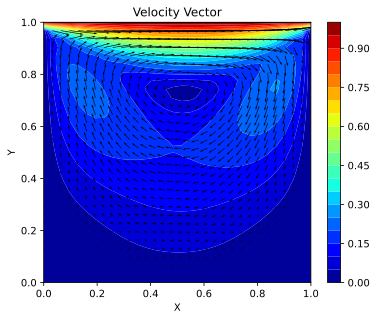

In [247]:
# Vector
frame = -1
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

width = 6
fig, ax = plt.subplots(figsize = (width, (Ly/Lx)*width*0.8))
cont = ax.contourf(X, Y, np.sqrt(u_sol[-1]**2 + v_sol[-1]**2), cmap = plt.cm.jet, levels = 20)
ax.quiver(X, Y, u_sol[frame], v_sol[frame], scale=5)
plt.colorbar(cont, ax=ax)
ax.set(xlabel = 'X', ylabel = 'Y', title = 'Velocity Vector', xlim = [X[0, 0], X[0, -1]], ylim = [Y[0, 0], Y[-1, 0]])
plt.show()

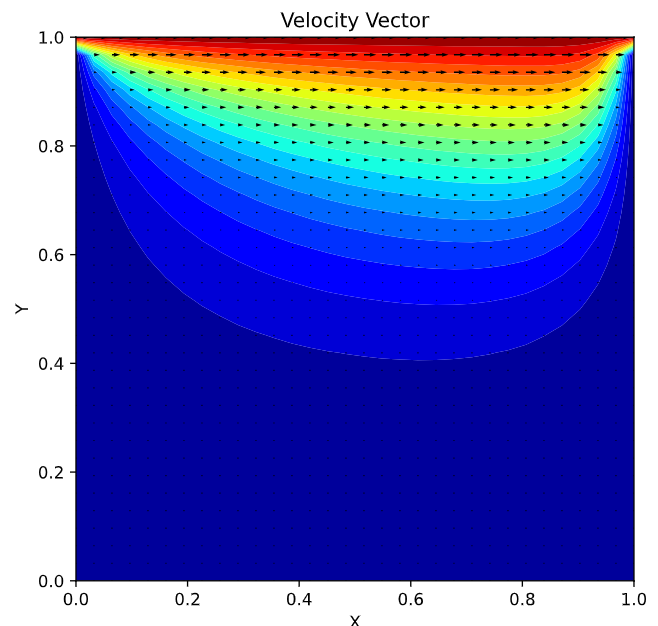


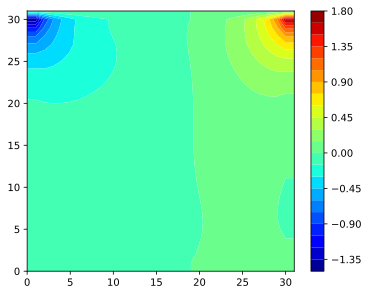

In [278]:
width = 6
plt.figure(figsize = (width, (Ly/Lx)*width*0.8))
plt.contourf(p_sol[-1], cmap = plt.cm.jet, levels = 20)
plt.colorbar()
plt.show()

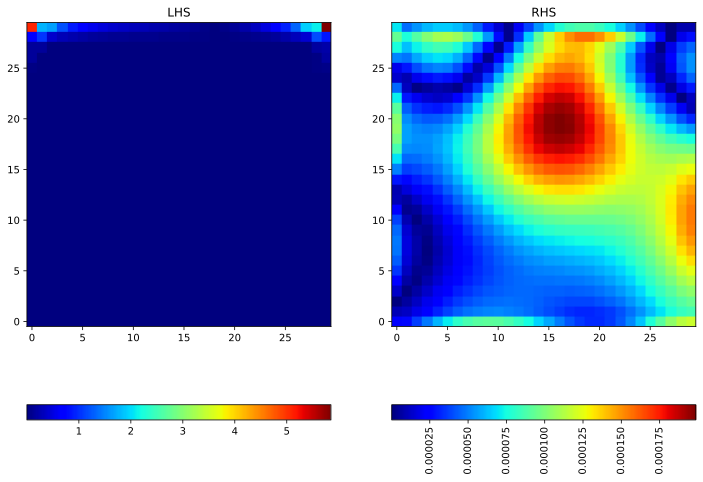

In [272]:
# Check mass conservation (through continuity)
#LHS
u_f = u_sol[-1]
v_f = v_sol[-1]
div_u = (u_f[1:-1, 2:] - u_f[1:-1, :-2])/(2*dx) + (v_f[2:, 1:-1] - v_f[:-2, 1:-1])/(2*dy)

#RHS
p_f = p_sol[-1]
div_up = (u_p[1:-1, 2:] - u_p[1:-1, :-2])/(2*dx) + (v_p[2:, 1:-1] - v_p[:-2, 1:-1])/(2*dy)
del2_p = (p_f[1:-1, 2:]-2*p_f[1:-1, 1:-1]+p_f[1:-1, :-2])/(dx*dx) + (p_f[2:, 1:-1]-2*p_f[1:-1, 1:-1]+p_f[:-2, 1:-1])/(dy*dy)
div_rhs = div_up - (dt/ρ)*del2_p

# Plot
width = 12
fig, ax = plt.subplots(figsize = (width, (Ly/Lx)*width*0.8), ncols = 2)
cont1 = ax[0].imshow(abs(div_u), cmap = plt.cm.jet, origin = 'lower')
cont2 = ax[1].imshow(abs(div_rhs), cmap = plt.cm.jet, origin = 'lower')
plt.colorbar(cont1, ax=ax[0], orientation = 'horizontal')
cbar2 = plt.colorbar(cont2, ax=ax[1], orientation = 'horizontal')
cbar2.ax.xaxis.set_tick_params(rotation = 90)
ax[0].set(title = 'LHS')
ax[1].set(title = 'RHS')
plt.show()

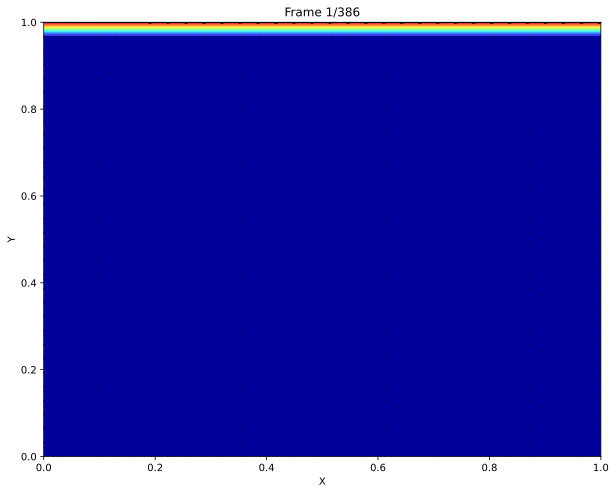

In [285]:
# Streamline animation
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)
width = 10
fig, ax = plt.subplots(figsize = (width, (Ly/Lx)*width*0.8))
def update(frame):
    ax.clear()  # Clear the previous plot
    ax.contourf(X, Y, np.sqrt(u_sol[frame]**2 + v_sol[frame]**2), cmap = plt.cm.jet, levels = 20)
    ax.quiver(X, Y, u_sol[frame], v_sol[frame], scale=5)
    ax.set(xlabel = 'X', ylabel = 'Y', title = f'Frame {frame + 1}/{len(u_sol)}', xlim = [X[0, 0], X[0, -1]], ylim = [Y[0, 0], Y[-1, 0]])

animation = anm.FuncAnimation(fig, update, frames=list(range(0, len(u_sol), int(len(u_sol)/100)))+[len(vel_sol)-1], repeat=False)
animation

In [15]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [16]:
animation.save('streamline_animation.gif', writer = 'pillow', fps = 10)

- Streamlines looked a bit off initially. More like equipotential lines, since they look perpendicular to constant stream-function lines. It seems I used $\partial\psi/\partial x$ without the negative sign for y component of velocity.
- One can observe the primary vortex at the centre and a secondary vortex developing in the animation at around frame 700-800 (time = 0.7-0.8s) on the bottom left of the domain